Bert-vits2音频模型训练

In [ ]:
import json
input_directory='/root/autodl-tmp/DATA/Preprocessed'
config_path='/root/Bert-VITS2/configs/base.json'
target_steps_range=(14000, 15000)  #设置训练步数范围，不是很准，可以算个大概
batch_size=14
learning_rate=0.0002



def calculate_epochs(total_steps,batch_size,target_steps_range):
    for epoch in range(1, 1000):  # 假设一个最大的epoch数，这里设置为1000
        steps_per_epoch = total_steps/batch_size * epoch
        if target_steps_range[0] <= steps_per_epoch <= target_steps_range[1]:
            return epoch
    return 1  # 如果没有合适的epoch数，返回默认值1


filelist = os.listdir(input_directory)

# def update_config(config_path, audio_file_count):
    # 读取配置文件
with open(config_path, 'r') as config_file:
    config = json.load(config_file)

# 计算epochs数
epochs_count = calculate_epochs(len(os.listdir(input_directory)) ,batch_size,target_steps_range)
print(f"计算得到的epoch数为：{epochs_count}")
print(f"batch_size为：{batch_size}")
print(f"learning_rete为：{learning_rate}")

config['train']['epochs'] = epochs_count
config['train']['batch_size'] = batch_size
config['train']['learning_rate'] = learning_rate

with open(config_path, 'w') as config_file:
    json.dump(config, config_file, indent=4)
print(f"配置文件{config_path}已更新。")

In [ ]:
!cp -r /root/model/* /root/autodl-tmp/model/
import json
with open('/root/autodl-tmp/DATA/Parameter_save.json', 'r') as file:
    data = json.load(file)
    character_name = data["character_name"]

%cd /root/Bert-VITS2
%run preprocess_text.py --transcription-path /root/autodl-tmp/DATA/{character_name}.list --config-path  /root/Bert-VITS2/configs/base.json

In [ ]:
%cd /root/Bert-VITS2
%run bert_gen.py  -c /root/Bert-VITS2/configs/base.json
torch.cuda.empty_cache()

In [ ]:
%cd /root/Bert-VITS2
%run train_ms.py -m /root/autodl-tmp/model

### LLM训练

2023-12-02 17:10:06.802389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 17:10:07.547384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ChatGLMTokenizer(name_or_path='/root/autodl-tmp/chatglm3-6b', vocab_size=64798, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='left', truncation_side='right', special_tokens={}, clean_up_tokenization_spaces=False)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/1143 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1143 [00:00<?, ? examples/s]

trainable params: 2,924,880 || all params: 6,246,508,908 || trainable%: 0.04682423483386154
<<<<<< ⚡️ cuda is used >>>>>>


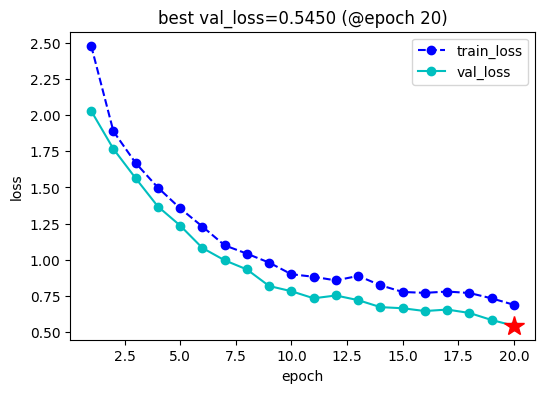

LLM模型训练完毕


In [1]:
from multiprocessing import Process
import os
import shutil
import gc
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader
import datasets
from transformers import AutoConfig, AutoTokenizer, AutoModel, DataCollatorForSeq2Seq
from peft import get_peft_model, AdaLoraConfig, TaskType
from torchkeras import KerasModel 
from tools.train_utils import StepRunner, save_ckpt, load_ckpt

# Ignore warnings with caution
import warnings
warnings.filterwarnings('ignore')

# 全局变量和配置
import json
torch.cuda.empty_cache()
gc.collect()
# 打开 JSON 文件
JSON_path = "/root/autodl-tmp/DATA/Parameter_save.json"
with open(JSON_path, 'r') as file:
    # 解析 JSON 数据
    Parameter_save = json.load(file)

character_name = Parameter_save['character_name']
ZH_character_name = Parameter_save['character_name_ZH']
old_model_name = "/root/autodl-tmp/chatglm3-6b" 
train_data_path = "/root/autodl-tmp/DATA/LLMdata.csv"
save_list = [5,10,15]  #保存的epoch
ckpt_path = f'/root/autodl-tmp/check_point/ckpt_chatglm3-{character_name}'
cfg = Namespace()
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' #添加到每个prompt开头的前缀引导语

cfg.max_source_length = 128
cfg.max_target_length = 128

#model
cfg.model_name_or_path = old_model_name  #远程'THUDM/chatglm-6b' 
cfg.quantization_bit = None #仅仅预测时可以选 4 or 8 

#train
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 7
cfg.gradient_accumulation_steps = 16 #梯度累积

def preprocess_train_data(tokenizer,dfdata,cfg):
    def preprocess(examples):
        max_seq_length = cfg.max_source_length + cfg.max_target_length
        model_inputs = {
            "input_ids": [],
            "labels": [],
        }
        for i in range(len(examples[cfg.prompt_column])):
            if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
                query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

                history = examples[cfg.history_column][i] if cfg.history_column is not None else None
                prompt = tokenizer.build_prompt(query, history)
                # prompt = ' '.join(history + [query])  # 假设简单空格分隔足够

                prompt = cfg.source_prefix + prompt
                a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                         max_length=cfg.max_source_length)
                b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                         max_length=cfg.max_target_length)

                context_length = len(a_ids)
                input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
                labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

                pad_len = max_seq_length - len(input_ids)
                input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
                labels = labels + [tokenizer.pad_token_id] * pad_len
                labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
                model_inputs["input_ids"].append(input_ids)
                model_inputs["labels"].append(labels)
        return model_inputs

    ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)
    ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
    )

    ds_val = ds_val_raw.map(
        preprocess,
        batched=True,
        num_proc=4,
        remove_columns=ds_val_raw.column_names
    )
    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        model=None,
        label_pad_token_id=-100,
        pad_to_multiple_of=None,
        padding=False
    )

    dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                          num_workers = 4, shuffle = True, collate_fn = data_collator 
                         )
    dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                          num_workers = 4, shuffle = False, collate_fn = data_collator 
                         )
    return dl_train,dl_val

class MyCallback:
    def __init__(self,old_model_name, ckpt_path,save_list,character_name):
        self.old_model_name = old_model_name
        self.ckpt_path = ckpt_path
        self.save_list = save_list
        self.character_name = character_name

    def on_train_epoch_end(self, model):
        epoch = model.history['epoch'][-1] -1
        if epoch not in self.save_list: return 
        loss = model.history['val_loss'][-1]
        src_folder = self.ckpt_path
        dest_folder = src_folder + f"_Loss-{loss:.3f}_epoch{epoch}"
        dest_folder.replace(".","_")
        # 确保源文件夹存在
        if not os.path.exists(src_folder) or not os.path.isdir(src_folder):
            print(f"源文件夹 {src_folder} 不存在或不是一个目录。")
            return

        # 如果目标文件夹不存在，创建它
        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        # 遍历源文件夹中的所有文件和目录
        for filename in os.listdir(src_folder):
            src_path = os.path.join(src_folder, filename)
            dest_path = os.path.join(dest_folder, filename)
            # 如果是文件夹，则递归复制
            if os.path.isdir(src_path):
                shutil.copytree(src_path, dest_path)
            else:  # 如果是文件，则直接复制
                shutil.copy2(src_path, dest_path)

def train_peft_model(model, cfg, dl_train, dl_val, ckpt_path):
    # 创建PEFT配置
    peft_config = AdaLoraConfig(
        task_type=TaskType.CAUSAL_LM, 
        inference_mode=False,
        r=8,
        lora_alpha=32, lora_dropout=0.1,
        target_modules=["query_key_value"]
    )

    peft_model = get_peft_model(model, peft_config)
    peft_model.is_parallelizable = True
    peft_model.model_parallel = True
    peft_model.print_trainable_parameters()
    
    # 扩展KerasModel以支持checkpoint保存和加载
    KerasModel.StepRunner = StepRunner 
    KerasModel.save_ckpt = save_ckpt
    KerasModel.load_ckpt = load_ckpt

    # 初始化优化器
    optimizer = torch.optim.AdamW(peft_model.parameters(), lr=cfg.lr)
    
    # 创建KerasModel实例
    keras_model = KerasModel(peft_model, 
                             loss_fn=None, 
                             optimizer=optimizer,
                            ) 
    # 创建回掉函数
    my_call_back = MyCallback(old_model_name, ckpt_path,save_list,character_name)
    
    # 开始训练
    keras_model.fit(
        train_data=dl_train,
        val_data=dl_val,
        epochs=20,
        patience=60,
        monitor='val_loss',
        mode='min',
        ckpt_path=ckpt_path,
        mixed_precision='fp16',
        gradient_accumulation_steps=cfg.gradient_accumulation_steps,
        callbacks=[my_call_back]
    )
    return keras_model

def train_main():
    try:
        config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)
        tokenizer = AutoTokenizer.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)
        print(tokenizer)
        if torch.cuda.is_available():
            model = AutoModel.from_pretrained(cfg.model_name_or_path, config=config, trust_remote_code=True).half()
            if cfg.quantization_bit is not None:
                print(f"Quantized to {cfg.quantization_bit} bit")
                model = model.quantize(cfg.quantization_bit)
            model.config.use_cache = False
            model.supports_gradient_checkpointing = True
            model.gradient_checkpointing_enable()
            model.enable_input_require_grads()
            model = model.cuda()
        else:
            model = AutoModel.from_pretrained(cfg.model_name_or_path, config=config, trust_remote_code=True)
            print("CUDA is not available. Using CPU.")

        dfdata = pd.read_csv(train_data_path)
        dl_train, dl_val = preprocess_train_data(tokenizer,dfdata, cfg)
        keras_model = train_peft_model(model, cfg, dl_train, dl_val, ckpt_path)
        print("LLM模型训练完毕")

        # 清空 CUDA 缓存
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            gc.collect()

    finally:
        exit(0)  # 显式地退出子进程

# 创建并启动进程
if __name__ == '__main__':
    p = Process(target=train_main())
    p.start()
    p.join()


### 模型保存

In [ ]:
import os
import shutil
from transformers import AutoModel, AutoTokenizer
from peft import PeftModel
from argparse import Namespace

# 全局变量和配置
import json

# 打开 JSON 文件
JSON_path = "/root/autodl-tmp/DATA/Parameter_save.json"
with open(JSON_path, 'r') as file:
    # 解析 JSON 数据
    Parameter_save = json.load(file)


character_name = Parameter_save['character_name']
ZH_character_name = Parameter_save['character_name_ZH']

old_model_path = "/root/autodl-tmp/chatglm3-6b" 

cfg = Namespace()
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column = None
cfg.source_prefix = '' # 添加到每个prompt开头的前缀引导语
cfg.max_source_length = 128 
cfg.max_target_length = 128
cfg.model_name_or_path = old_model_path
cfg.quantization_bit = None
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 7
cfg.gradient_accumulation_steps = 16

train_data_path = "/root/autodl-tmp/DATA/TR_data.csv"
ckpt_path = f'/root/autodl-tmp/check_point/ckpt_chatglm3-{character_name}'
save_path = f"/root/autodl-tmp/LLM-model/chatglm3-6b-{character_name}"

# 查找指定前缀的文件夹
def find_folders_with_prefix(root_folder, prefix):
    matching_folders = []
    for item in os.listdir(root_folder):
        item_path = os.path.join(root_folder, item)
        if os.path.isdir(item_path) and item.startswith(prefix):
            matching_folders.append(item_path)
    return matching_folders

# 保存并复制模型的函数
def save_and_copy_model():
    try:
        model_old = AutoModel.from_pretrained(old_model_path, load_in_8bit=False, trust_remote_code=True)
        tokenizer = AutoTokenizer.from_pretrained(old_model_path, trust_remote_code=True)
        model_shard_size = "2GB"
        
        root_folder = ckpt_path + "/../"
        prefix = ckpt_path.split("/")[-1] + "_"
        folders = find_folders_with_prefix(root_folder, prefix)
        folders.append("-1")

        for ckpt_path_temp in folders:
            if ckpt_path_temp == "-1":
                ckpt_path_temp = ckpt_path
                save_path_temp = save_path
            else:
                save_path_temp = save_path + "_" + ckpt_path_temp.split("/")[-1].replace(prefix,"")
            
            peft_loaded = PeftModel.from_pretrained(model_old, ckpt_path_temp).cuda()
            model_new = peft_loaded.merge_and_unload()
            model_new.save_pretrained(save_path_temp, max_shard_size=model_shard_size)
            tokenizer.save_pretrained(save_path_temp)
            
            os.makedirs(save_path, exist_ok=True)
            for file_name in os.listdir(old_model_path):
                if file_name.endswith('.py'):
                    shutil.copy(os.path.join(old_model_path, file_name), os.path.join(save_path_temp, file_name))

            if os.path.exists(ckpt_path_temp) and os.path.isdir(ckpt_path_temp):
                shutil.rmtree(ckpt_path_temp)
                print(f"Removed checkpoint directory: {ckpt_path_temp}")
        del model_old, tokenizer, peft_loaded, model_new
        import gc
        import torch
        # 调用垃圾回收器
        gc.collect()
        # 再次清空PyTorch的GPU缓存
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    finally:
        print("保存完成")

if __name__ == '__main__':
    save_and_copy_model()


2023-12-02 21:39:47.825423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 21:39:48.584402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
old_model_path = "/root/autodl-tmp/chatglm3-6b" 
for file_name in os.listdir(old_model_path):
    if file_name.endswith('.py'):
        print(file_name)

configuration_chatglm.py
modeling_chatglm.py
quantization.py
tokenization_chatglm.py


In [4]:
import glob
import shutil; [shutil.copy(file, '/root/autodl-tmp/LLM-model/chatglm3-6b-JiaRan_Loss-1.237_epoch5/') for file in glob.glob('/root/autodl-tmp/chatglm3-6b/*py')]


['/root/autodl-tmp/LLM-model/chatglm3-6b-JiaRan_Loss-1.237_epoch5/configuration_chatglm.py',
 '/root/autodl-tmp/LLM-model/chatglm3-6b-JiaRan_Loss-1.237_epoch5/modeling_chatglm.py',
 '/root/autodl-tmp/LLM-model/chatglm3-6b-JiaRan_Loss-1.237_epoch5/quantization.py',
 '/root/autodl-tmp/LLM-model/chatglm3-6b-JiaRan_Loss-1.237_epoch5/tokenization_chatglm.py']